In [1]:
import numpy as np
from pandas import array
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var        = 2,       # 两个自变量
            n_obj        = 2,       # 两个目标函数
            n_ieq_constr = 2,       # 两个不等式约束
            xl           = np.array([-2, -2]),  # 两个自变量下限
            xu           = np.array([2, 2])     # 两个自变量上限
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)  # 目标函数f1
        f2 = (x[0] - 1)**2 + x[1]**2    # 目标函数f2

        g1 = 2 * (x[0] - 0.1) * (x[0] - 0.9) / 0.18
        g2 = -20 * (x[0] - 0.4) * (x[0] - 0.6) / 4.8

        out["F"] = [f1, f2]     # 计算得到的目标存放的位置
        out["G"] = [g1, g2]     # 计算得到的约束存放的位置

problem = MyProblem()

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size             = 40,      # 种群规模
    n_offspring          = 10,      # 生成的子代规模
    sampling             = FloatRandomSampling(),   # 随机抽样算子
    crossover            = SBX(prob=0.9, eta=15),   # 模拟二元交叉算子
    mutation             = PM(eta=20),              # 多项式突变算子
    eliminate_duplicates = True     # 去除重复的个体
)

In [3]:
from matplotlib.cbook import flatten
from pymoo.util.misc import stack

class MyTestProblem(MyProblem):

    # 计算优化问题的Pareto前沿（目标空间）
    def _calc_pareto_front(self, flatten=True, *args, **kwargs):
        # 理论上分析一个标优化问题的Pareto前沿，其实就是寻找目标函数之间的函数关系
        # 具体为什么 f1 与 f2 的关系为如下表达式，可以参考：
        # https://blog.csdn.net/weixin_37926734/article/details/127392027?spm=1001.2014.3001.5501
        f2 = lambda f1: ((f1 / 100) ** 0.5 - 1)**2
        # f1 满足Pareto集的区间
        F1_a, F1_b = np.linspace(1, 16, 300), np.linspace(36, 81, 300)
        # 根据 f1 的区间，得到对应的 f2 值
        F2_a, F2_b = f2(F1_a), f2(F1_b)

        # 由于Pareto前沿是分段函数，所以需要分开处理
        pf_a = np.column_stack([F1_a, F2_a])
        pf_b = np.column_stack([F1_b, F2_b])

        return stack(pf_a, pf_b, flatten=flatten)

    # 计算优化问题的Pareto集 (变量空间)
    def _calc_pareto_set(self, *args, **kwargs):
        # 定义优化问题的Pareto集合的本质是确定满足问题最优解的自变量区间
        # 具体的区间确定方法同样可以参考：https://blog.csdn.net/weixin_37926734/article/details/127392027?spm=1001.2014.3001.5501
        # 对于本文的`MyProblem`定义的问题其Pareto集合可以从理论分析上得到：
        # x2 = 0, x 属于 [0.1, 0.4]与[0.6, 0.9] 两个区间，因此代码如下所示：
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a, b, flatten=flatten)

problem = MyTestProblem()

In [4]:
from pymoo.optimize import minimize

res = minimize(
    problem,
    algorithm,
    ('n_gen', 40),
    save_history=True,
    verbose=False
)

X, F = res.opt.get("X", "F")
hist = res.history

In [7]:
n_evals = []        # 函数迭代的次数（Corresponding number of function evaluations）
hist_F = []         # 每一代目标空间中的目标值
hist_cv = []        # 在每一代的约束冲突 (Constraint Violation)
hist_cv_avg = []    # 整个种群的平均约束冲突 (Average Constraint Violation)

for algo in hist:
    # Store the number of function evaluations
    # 存储功函数计算的次数
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    # 从算法中检索最优值
    opt = algo.opt

    # store the least contraint violation and the average in each population
    # 存储最新的约束冲突与种群的平均约束冲突
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    # 只过滤出可行的、附加的和目标的空间值
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

In [8]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 0 after 40 evaluations.


Whole population feasible in Generation 3 after 160 eavaluations.


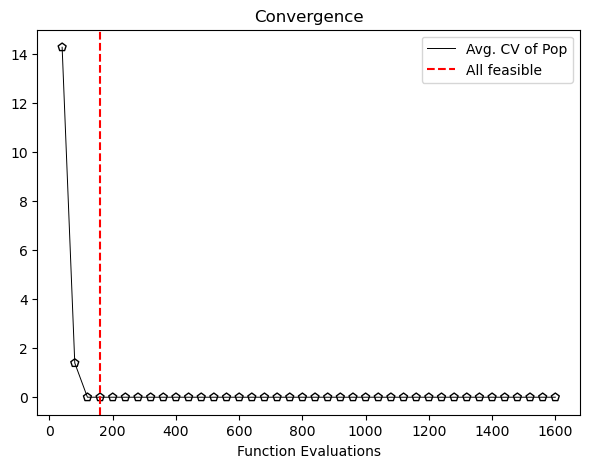

In [9]:
from matplotlib import pyplot as plt
# 如果最新的可行解而不是总体的平均值，可以替换为 hist_cv

vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} eavaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals, color="black", lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals, facecolor="none", edgecolor='black', marker="p")

# 绘制一条垂直于 x 轴的一条经过第一次出现可行解处
plt.axvline(n_evals[k], color="red", label="All feasible", linestyle="--")

plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.legend()
plt.show()

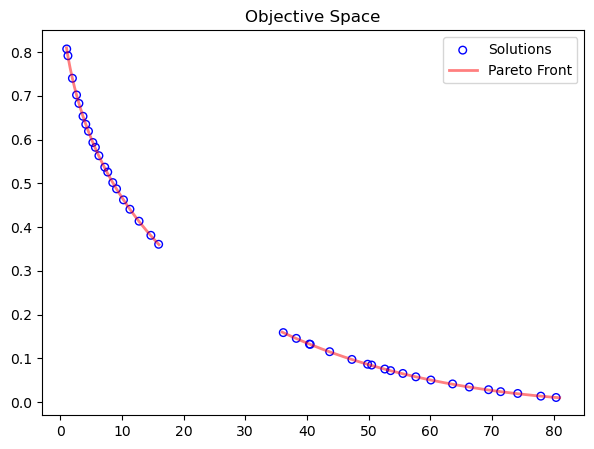

In [10]:
# 获取Pareto前沿
# pf = problem.pareto_front(use_cache=False, flatten=True)
pf_a, pf_b = problem.pareto_front(use_cache=False, flatten=False)

# 绘制结果
plt.figure(figsize=(7, 5))

# 首先绘制优化算法计算得到的最优解
plt.scatter(F[:, 0], F[:, 1], s=30, facecolor="none", edgecolors="b", label="Solutions")

# 然后绘制理论分析得到的Pareto前沿 pf_a, pf_b
plt.plot(pf_a[:, 0], pf_a[:, 1], alpha=0.5, linewidth=2.0, color="red", label="Pareto Front")
plt.plot(pf_b[:, 0], pf_b[:, 1], alpha=0.5, linewidth=2.0, color="red")

plt.title("Objective Space")
plt.legend()
plt.show()


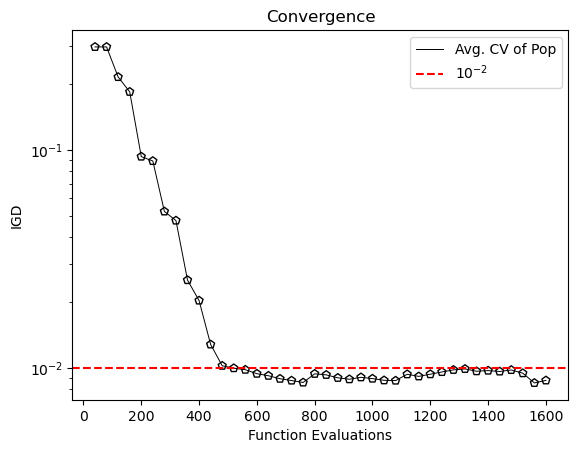

In [12]:
from pymoo.indicators.igd import IGD

# 获取求解问题的Pareto前沿
pf = problem.pareto_front(use_cache=False, flatten=True)

# 算法性能评价指标IGD对象的定义
metric = IGD(pf, zero_to_one=True)

# 计算优化算法计算的最优解与Pareto前沿的IGD指标
igd = [metric.do(_F) for _F in hist_F]

# 绘制收敛分析结果
# 首先绘制igd性能指标的结果
plt.plot(n_evals, igd, color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd, facecolor="none", edgecolor="black", marker="p")

# 绘制一条满足收敛条件（这里假设为10^-2）的一条垂直于y轴的直线
plt.axhline(10**(-2), color="red", label="$10^{-2}$", linestyle="--")

plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
# y 轴使用log刻度
plt.yscale("log")
plt.legend()
plt.show()

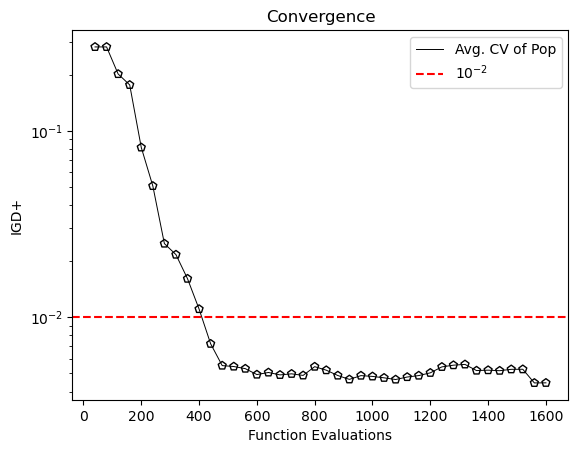

In [13]:
from pymoo.indicators.igd_plus import IGDPlus

# 算法性能评价指标IGD+对象的定义
metric = IGDPlus(pf, zero_to_one=True)

# 计算优化算法计算的最优解与Pareto前沿的IGD+指标
igd_plus = [metric.do(_F) for _F in hist_F]

# 绘制收敛分析结果
# 首先绘制igd+性能指标的结果
plt.plot(n_evals, igd_plus, color="black", lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd_plus, facecolor="none", edgecolor="black", marker="p")

# 绘制一条满足收敛条件（这里假设为10^-2）的一条垂直于y轴的直线
plt.axhline(10**-2, color="red", label="$10^{-2}$", linestyle="--")

plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD+")
plt.yscale("log")
plt.legend()
plt.show()

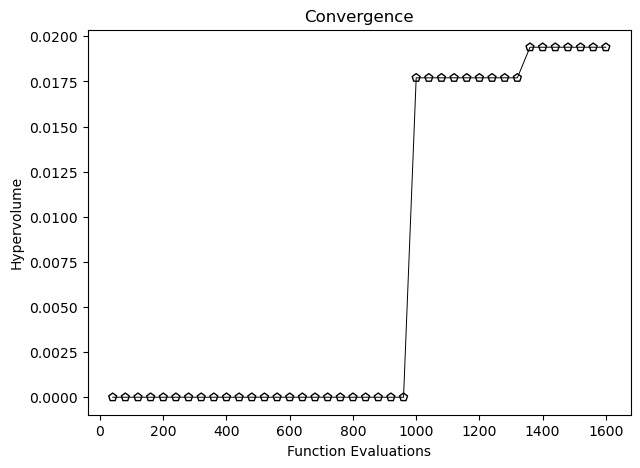

In [14]:
# 沿着F的行方向，获得计算得到的目标值中的最小值与最大值
approx_idel = F.min(axis=0)
approx_nadir = F.max(axis=0)

from pymoo.indicators.hv import Hypervolume

# 算法性能评价指标Hypervolume对象的定义
metric = Hypervolume(
    ref_point=np.array([1.1, 1.1]),
    norm_ref_point=False,
    ideal=approx_idel,
    nadir=approx_nadir
)

# 根据算法求得的最优解计算Hypervolume指标
hv = [metric.do(_F) for _F in hist_F]

# 绘制收敛分析结果
plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

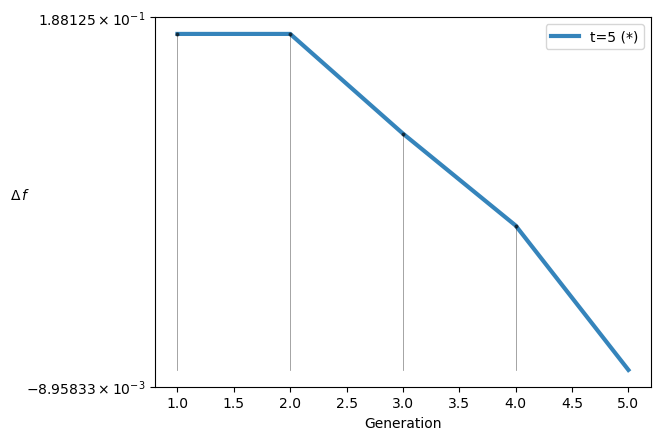

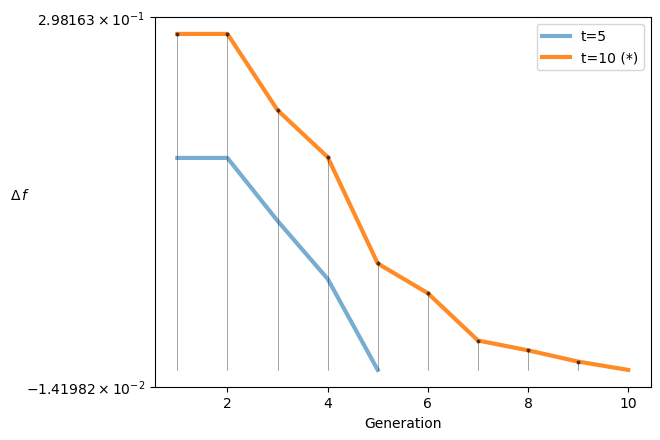

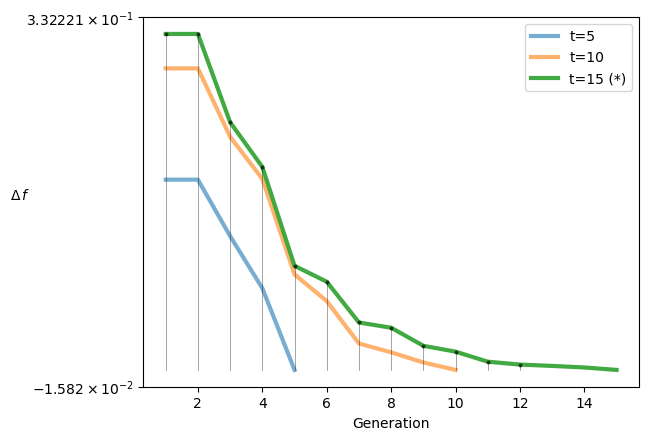

In [15]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(
    delta_gen=5,
    n_plots=3,
    key_press=False,
    do_show=True
)

for algorithm in res.history[:15]:
    running.update(algorithm)

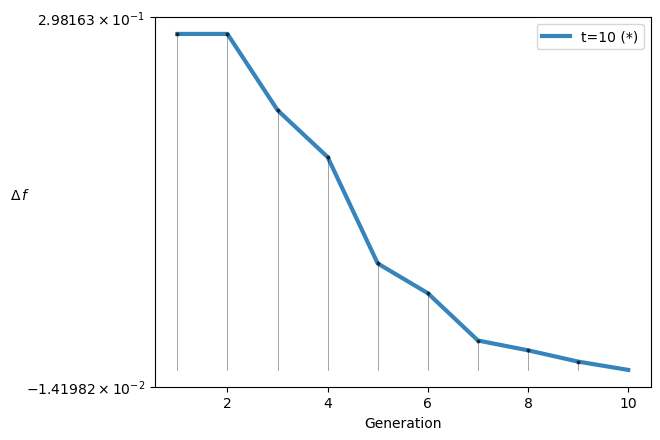

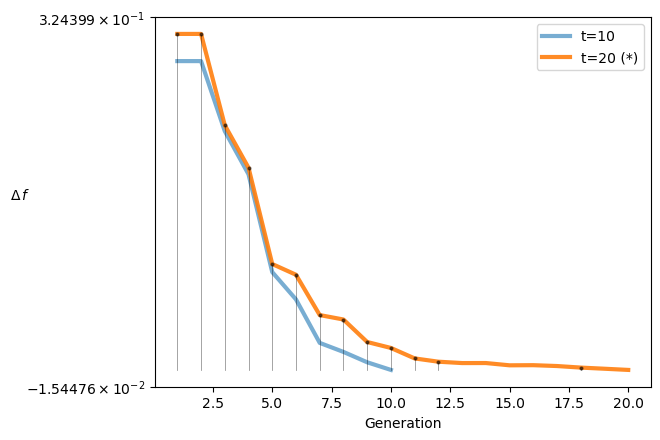

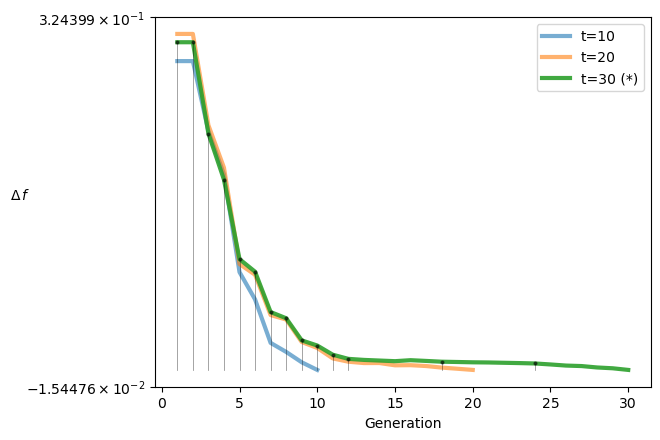

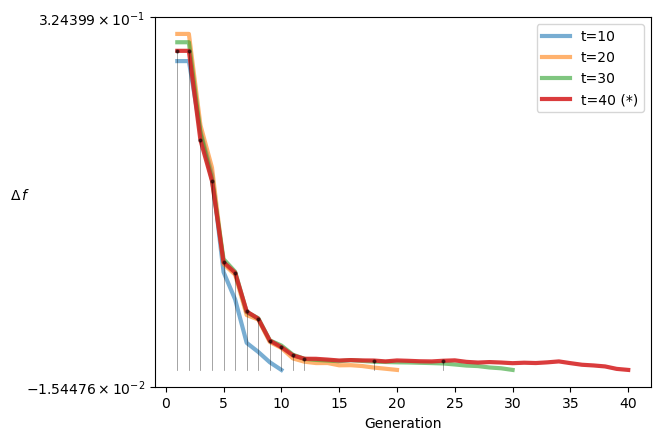

In [16]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetricAnimation(delta_gen=10,
                        n_plots=4,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)